# Creating a temporal varying eddy

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from wave_tracing_FE import Wave_tracing_FE
from scipy.stats import norm
import cmocean
import netCDF4# import Dataset

%matplotlib inline

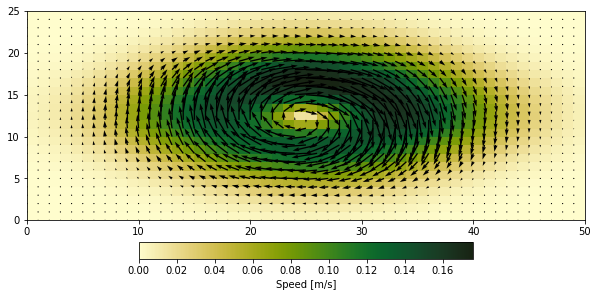

In [2]:
# A theoretical eddy
nx, ny = (50, 25)
x = np.linspace(-1, 0, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)
u = np.pi*np.sin(np.pi*xv)*np.cos(np.pi*yv)
v = -np.pi*np.cos(np.pi*xv)*np.sin(np.pi*yv)

# weighten with a bell curve
x_weight = norm.pdf(np.arange(-3, 3, 6/nx),0,1)
y_weight = norm.pdf(np.arange(-3, 3, 6/ny),0,1)

#u/=np.pi
#v/=np.pi

for idx in range(u.shape[0]):
    u[idx,:] *= x_weight
    v[idx,:] *= x_weight

for idy in range(u.shape[1]):
    u[:,idy] *= y_weight
    v[:,idy] *= y_weight

#u*=x_weight
#v*=x_weight



fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,5))
pc0 = ax.pcolormesh(np.sqrt(u**2 + v**2),cmap=cmocean.cm.speed)
ax.quiver(u,v)
fig.colorbar(pc0,ax=ax,orientation='horizontal',shrink=0.6,pad=0.08,label="Speed [m/s]")

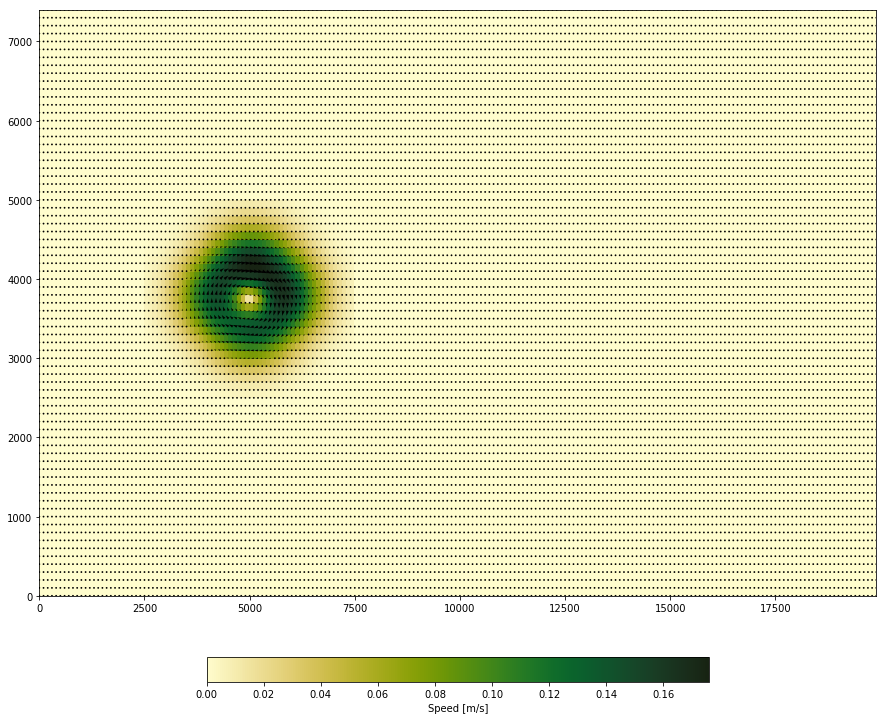

In [5]:
# Insert theoretical eddy in larger domain
dx=dy=100 #m

nny, nnx = (200,75)
xx = np.arange(nnx)*dx
yy = np.arange(nny)*dy
uu = np.zeros((nnx,nny))
vv = uu.copy()

uu[25:50,25:75] = u

vv[25:50,25:75] = v

speed = np.sqrt(uu**2 + vv**2)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(15,14))
pc0 = ax.pcolormesh(yy,xx,speed,cmap=cmocean.cm.speed)
ax.quiver(yy,xx,uu,vv,scale=25, scale_units='width')
fig.colorbar(pc0,ax=ax,orientation='horizontal',shrink=0.6,pad=0.08,label="Speed [m/s]")

In [57]:
nt = 24
U = np.zeros((nt,nnx,nny))
V = np.zeros((nt,nnx,nny))
SPEED = np.zeros((nt,nnx,nny))

temporal_weight=np.sin(np.linspace(0,np.pi,nt))

for idt,weight in enumerate(temporal_weight):
    U[idt,:,:] = weight*uu
    V[idt,:,:] = weight*vv
    SPEED[idt,:,:] = np.sqrt((weight*uu)**2 + (weight*vv)**2)

In [47]:
import datetime
t_acq = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00', dtype='datetime64[h]')
td = t_acq-np.datetime64('1970-01-01T00:00:00') 

array([946684800, 946688400, 946692000, 946695600, 946699200, 946702800,
       946706400, 946710000, 946713600, 946717200, 946720800, 946724400,
       946728000, 946731600, 946735200, 946738800, 946742400, 946746000,
       946749600, 946753200, 946756800, 946760400, 946764000, 946767600],
      dtype='timedelta64[s]')

24

In [58]:
# Create nc file
out_netcdf = 'eddy.nc'

with (netCDF4.Dataset(out_netcdf, 'w', format='NETCDF4')) as ncout:
    dim_time = ncout.createDimension('time',nt)
    dim_x = ncout.createDimension('x',nnx)
    dim_y = ncout.createDimension('y',nny)
    nctime = ncout.createVariable('time','i4',('time',))

    # Set time value
    ##########################################################
    nctime.long_name = 'reference time for eddy'
    nctime.units = 'seconds since 1970-01-01 00:00:00'
    nctime.calendar = 'gregorian'
    nctime[:] = td
    
    # Add projection coordinates
    ##########################################################
    # Status
    
    ncx = ncout.createVariable('x','i4', 'x', zlib=True)
    ncx.units = 'm'
    ncx.standard_name= 'projection_x_coordinate'
    ncx[:] = xx
    ncy = ncout.createVariable('y','i4', 'y', zlib=True)
    ncy.units = 'm'
    ncy.standard_name= 'projection_y_coordinate'
    ncy[:] = yy
    
    # ADD U
    varout_u = ncout.createVariable('U',np.float32,
                    ('time', 'x', 'y'), fill_value=0, zlib=True)
    varout_u.units = "meter second-1";                    
    varout_u.standard_name = 'x_sea_water_velocity'
    varout_u[:] = U
    
    # ADD V
    varout_v = ncout.createVariable('V',np.float32,
                    ('time', 'x', 'y'), fill_value=0, zlib=True)
    varout_v.units = "meter second-1";                    
    varout_v.standard_name = 'y_sea_water_velocity'
    varout_v[:] = V
    
    # ADD SPEED
    varout_sp = ncout.createVariable('speed',np.float32,
                    ('time', 'x', 'y'), fill_value=0, zlib=True)
    varout_sp.units = "meter second-1";                    
    varout_sp.standard_name = 'speed'
    varout_sp[:] = SPEED
            